<h1 align = 'center'>Guessing Games</h1>
<h3 align = 'center'>machine learning, one step at a time</h3>
<h3 align = 'center'>Step 5. Going Downhill</h3>

#### 5. Let's try to play the dice game.

Remember: these are the rules:
<ul>
<li>the maximum score is 20
<li>roll a pair of dice, add them up, that's your score
<li>decide if you want to roll **both dice** again... if you do, add the roll to your score
<li>get as close as you can to a total of 20...
<li>but if you go over 20, your score is zero.
</ul>

Here is our function to roll a specified number of dice:

In [1]:
import random

def roll_dice(number_of_dice):
    
    sum = 0
    
    for i in range(0, number_of_dice):
        sum += random.randrange(6)+1     # randrange is 0 through 5, so add 1 to get a six-sided die roll
    return sum


roll_dice(2)

3

The key to the game is deciding when to roll (again) without going over the maximum score.

So for any score, the program needs to guess whether rolling again is a good idea.

In [69]:
def play(limit):
    
    total_score = roll_dice(2)        # start by rolling two dice
    
    while total_score <= limit:       # if the score is at or under the limit...
        total_score += roll_dice(2)   # roll again, and add to score
        
    if total_score <= 20:
        return total_score            # if total is 20 or less, that's your score...
    else:
        return 0                      #  but if you go over 20, your score is zero.

Just for fun, let's say that we decide to roll if our total is less than 15, and we play 10 times:

In [70]:
for i in range(0,10):
    print(play(15))

19
16
16
17
19
0
16
16
19
0


There's a pretty good chance that we won some, and we lost some. But hey, we did not put in a lot of effort... we just picked the limit of 15 arbitrarily.

How could we use machine learning to find the optimum limit? For starters, let's try to understand the relationship between the limit and the resulting score, using data visualization:

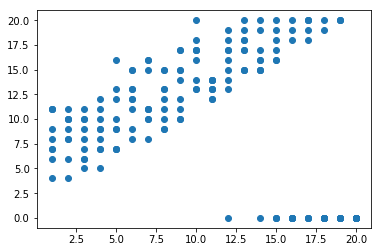

In [71]:
import matplotlib.pyplot as plt

limits = []
scores = []
    
for limit in range(1,21):            # for every limit from 1 to 20...
    for i in range(1,10):            # play the games 10 times...
        limits.append(limit)         # and record the limit and the score
        scores.append(play(limit))

plt.plot(limits,scores,'o')

Those dots suggest that higher limits lead to higher scores, but if the limit is too high, you might just score zero

How about plotting limit versus average score?

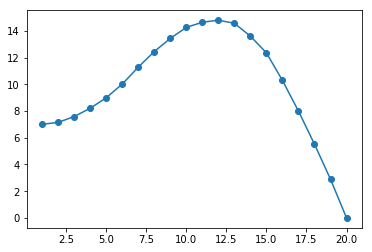

In [72]:
limits = []
scores = []
tries = 10000

for limit in range(1,21):                 # make lists for limits and total scores
    limits.append(limit)
    scores.append(0)

for limit in range(1,21):
    for i in range(1,tries):
        scores[limit-1] += play(limit)    # accumulate the total score in list of scores

for i in range(0, 20):
    scores[i] /= tries                    # convert to an average score (divide by the number of tries)
    
plt.plot(limits,scores,'o-')

Looks like the highest average score is around 13.

Could a program find the optimum limit if we set it up to guess, then learn from its mistakes, to get the highest average score?

17.042092517229918


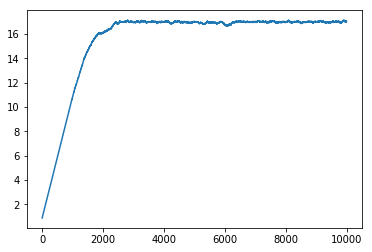

In [73]:
guess = random.random() * 20
guesses = []

for i in range(0,10000):
    guesses.append(guess)
    score = play(guess)
    if score > 0:
        guess += 0.01
    else:
        guess -= 0.01   

print(guess)
plt.plot(guesses)